Impordime eeltöödeldud andmed ja treenime Random Forestit (esialgu suvaliste parameetritega)

In [1]:
import pandas as pd
import numpy as np
X_train = pd.read_csv('X_train_sub.csv')
y_train = pd.read_csv('y_train_sub.csv')

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=32, max_depth=4, random_state=11).fit(X_train, y_train)

Impordime varasemalt eraldatud valideerimisandmestiku ja prognoosime tõenäosused selle peal

In [2]:
X_val = pd.read_csv('X_val.csv')
y_val = pd.read_csv('y_val.csv')
y_val = y_val.y

probs = rf.predict_proba(X_val)[1]
assert np.isclose(probs.sum(axis=1), 1).all() # check that all rows sum up to 1

probs = pd.DataFrame(probs, columns=['a', 'b']) # Store in pandas Dataframe with two columns
probs = probs.b # Keep only one column (store as a pandas Series)

probs

0       0.939557
1       0.162908
2       0.965486
3       0.928371
4       0.950363
          ...   
7652    0.051827
7653    0.945586
7654    0.164853
7655    0.965032
7656    0.618220
Name: b, Length: 7657, dtype: float64

Tekitame lävendite (*cutoff*) järjendi. Kuna kümnete tuhandete kirjete puhul pole mõtet võtta sellesse kõiki võimalikke ennustatud tõenäosusi, võtame need sammuga 0,5 protsendipunkti.

In [3]:
cutoffs = pd.DataFrame({'cutoff':np.arange(0.005,1,0.005)}) 
cutoffs

,cutoff
0,0.005
1,0.010
2,0.015
3,0.020
4,0.025
...,...
194,0.975
195,0.980
196,0.985
197,0.990


Arvutame *TPR* ja *FPR* indeksid ja *accuracy* iga lävendi puhul:

In [4]:
tpr = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut.iloc[0], y_val == 1)) / np.sum(y_val == 1), axis=1)
fpr = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut.iloc[0], y_val == 0)) / np.sum(y_val == 0), axis=1)

stats = pd.DataFrame({'cutoff':cutoffs.cutoff, 'tpr':tpr, 'fpr':fpr})

tp_count = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut.values[0], y_val == 1)), axis=1)
fp_count = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut.values[0], y_val == 0)), axis=1)
tn_count = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs < cut.values[0], y_val == 0)), axis=1)
fn_count = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs < cut.values[0], y_val == 1)), axis=1)

stats['tp_count'] = tp_count
stats['fp_count'] = fp_count
stats['tn_count'] = tn_count
stats['fn_count'] = fn_count
stats['accuracy'] = (stats['tp_count'] + stats['tn_count']) / len(probs)
stats['precision'] = stats['tp_count'] / (stats['tp_count'] + stats['fp_count'])
stats['recall'] = stats['tp_count'] / (stats['tp_count'] + stats['fn_count'])

Leiame parimad väärtused:

In [5]:
cutoff1 = stats.accuracy.idxmax(axis=0, skipna=True)
print('Max accuracy: ', stats.loc[cutoff1]['accuracy'], ' ( cutoff ', stats.loc[cutoff1]['cutoff'], ')\n')

cutoff2 = stats.precision.idxmax(axis=0, skipna=True)
print('Max precision: ', stats.loc[cutoff2]['precision'], ' ( cutoff ', stats.loc[cutoff2]['cutoff'], ')\n')


Max accuracy:  1.0  ( cutoff  0.49 )

Max precision:  1.0  ( cutoff  0.49 )



Tekitame *ROC* kõvera:

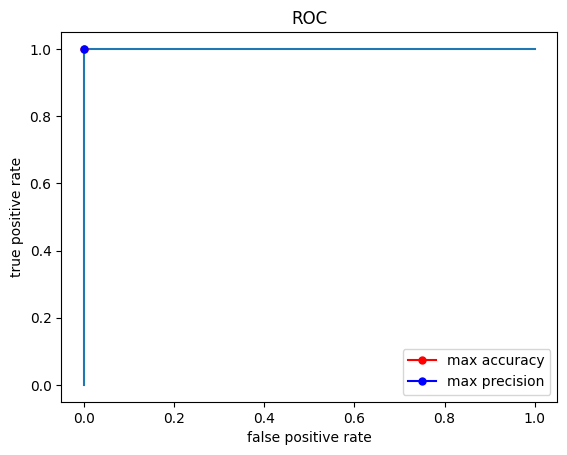

In [6]:
import matplotlib.pyplot as plt
plt.title("ROC")
plt.plot(stats['fpr'], stats['tpr'])
plt.plot(stats.loc[cutoff1]['fpr'], stats.loc[cutoff1]['tpr'], color='red', marker='o', markersize=5, label="max accuracy")
plt.plot(stats.loc[cutoff2]['fpr'], stats.loc[cutoff2]['tpr'], color='blue', marker='o', markersize=5, label="max precision")
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()